<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/recurrent_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import shutil
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torchvision import datasets, transforms


drive.mount('/content/drive')
# Define source and destination paths
source_path = "/content/drive/My Drive/Colab Notebooks/recurrent_model.ipynb"
destination_path = "/content/drive/My Drive/recurrent_model.ipynb"

  # Check if the source file exists before moving
if os.path.exists(source_path):
  # Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")

!cp /content/drive/My\ Drive/data_preprocess.py /content/

from data_preprocess import (
    data_split as data_split,
    fit_visualization as fit_visualization,
    repeated_to_single_transactions as repeated_to_single_transactions,
    one_hot as one_hot,
    standardization as standardization,
    data_filter as data_filter,
    add_prev_avg_price as add_prev_avg_price,
    standardization as standardization,
    min_max_scaling as min_max_scaling,
    inverse_min_max_scaling as inverse_min_max_scaling
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
def create_sequence(data, seq_length=20):
    X_list, y_list, transaction_dates, image_urls = [], [], [], []

    grouped = data.groupby("artist")[["transaction_price",
                                      "transaction_year_semi", "image_url"]]

    for artist, group in grouped:
        prices = np.array(group["transaction_price"], dtype=np.float32)
        dates = np.array(group["transaction_year_semi"])  # Transaction dates
        images = np.array(group["image_url"])  # Corresponding image URLs



        # Create sequences using a sliding window
        for i in range(len(prices) - seq_length):
            X_list.append(prices[i : i + seq_length])  # Past `seq_length` prices
            y_list.append(prices[i + seq_length])      # Next price (target)
            transaction_dates.append(dates[i + seq_length])  # Corresponding transaction date
            image_urls.append(images[i + seq_length])  # Corresponding image URL

    # Convert lists to NumPy arrays
    X = np.array(X_list).reshape(-1, seq_length, 1)  # Reshape for LSTM
    y = np.array(y_list).reshape(-1, 1)

    return (
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32),
        transaction_dates,
        image_urls
    )

def train_test_split_recurrent(df, date_split, selected_vars):
    df = df.copy()
    df = repeated_to_single_transactions(df, image_url=True)
    df = data_filter(df, selected_vars)

    df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%d/%m/%Y')

    # Convert the input date_split to datetime format
    date_split = pd.to_datetime(date_split, format='%d/%m/%Y')


    # Now, filter the dataset based on the date_split (split by transaction_date)
    train_set = df[df["transaction_date"] < date_split]
    test_set = df[df["transaction_date"] >= date_split]

    # Extract the relevant columns for scaling
    features_to_scale = ['transaction_price']  # Assuming `transaction_price` is the column to scale

    # Apply log1p transformation to handle zeros and skewed distribution
    train_set[features_to_scale] = np.log1p(train_set[features_to_scale])
    test_set[features_to_scale] = np.log1p(test_set[features_to_scale])

    # Apply min-max scaling to the log-transformed data
    train_scaled, test_scaled, scaler = min_max_scaling(train_set[features_to_scale], test_set[features_to_scale])

    # Assign the scaled values back to the DataFrames
    train_set[features_to_scale] = train_scaled
    test_set[features_to_scale] = test_scaled

    # Returning the scaled training and test sets, along with the scaler
    return train_set, test_set, scaler

class RecurrentDataSet(torch.utils.data.Dataset):
    def __init__(self,data):
        self.X_recurrent, self.y_recurrent,
        self.transaction_date , self.image_url = create_sequence(data)


    def len(self):
        return len(self.X)

    def getitem(self,index):
        return self.X[index], self.y[index]



class Numerical_Model(nn.Module):
    def __init__(self, in_features):
        super(Numerical_Model, self).__init__()
        self.fc1 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 20)

        self.dropout = nn.Dropout(0.3)  # Lower dropout
        self.leaky_relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation for regression
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size,  output_size = 20):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,  batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        out,_ = self.lstm(x)
        out = out[:, -1, :]
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        return out


class CombinedModel(nn.Module):
    def __init__(self, in_features, output_size = 20):
        super(CombinedModel, self).__init__()
        self.numerical_model = Numerical_Model(in_features)
        self.lstm_model = LSTMModel(input_size=1, hidden_size=64, output_size)
        self.fc1 = nn.Linear(40, 20)
        self.fc2 = nn.Linear(20, 1)
        self.relu = nn.ReLU() # Assuming the final combined features are of size 20 (10 from each model)

    def forward(self, numerical_input, image_input):
        # Get features from the numerical model
        numerical_model  = self.numerical_model(numerical_input)
        recurrent_model = self.lstm_model()
        combined = torch.cat((numerical_model, recurrent_model), dim=1)
        output = self.relu(self.fc1(combined))
        output = self.relu(self.fc2(output))
        return output


def create_dataloaders(train_set, test_set, batch_size):
    train_dataset = RecurrentDataSet(train_set)
    test_dataset = RecurrentDataSet(test_set)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = RecurrentDataSet(test_set)
    return trainloader, testloader

def train(network, trainloader, testloader, epochs=30, eta=0.0002):

    optimizer = torch.optim.Adam(network.parameters(), lr=eta, weight_decay=1e-5)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=eta)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device)

    loss = torch.nn.MSELoss()
    val_loss = []

    for epoch in range(epochs):
        # Initialize the total loss for train and test data
        J_train = 0
        total_train_samples = 0  # Counter for number of train samples

        # Train the network on training data
        for x, t in trainloader:
            network.train()
            optimizer.zero_grad()
            x, t = x.to(device), t.to(device)
            z = network(x)
            t = t.view(-1, 1)
            J = loss(z, t)
            J_train += J.item() * x.size(0)
            total_train_samples += x.size(0)
            J.backward()
            optimizer.step()

        # Compute the average train loss
        avg_train_loss = J_train / total_train_samples

        # Test on validation data
        J_test = 0
        total_test_samples = 0  # Counter for number of test samples
        with torch.no_grad():
            network.eval()
            for x, t in testloader:
                x, t = x.to(device), t.to(device)
                z = network(x)
                t = t.view(-1, 1)
                J_test += loss(z, t).item() * t.size(0)
                total_test_samples += t.size(0)

        # Compute the average test loss
        avg_test_loss = J_test / total_test_samples


        # Print train and test loss for each epoch
        print(f'Epoch [{epoch + 1}/{epochs}]',
              f'Train loss: {avg_train_loss:.6f}',
              f'Test loss: {avg_test_loss:.6f}')

    # save predictions and targets after last epoch
    pred, target = [],[]
    with torch.no_grad():
      network.eval()
      for x, t in testloader:
        prediction = network(x.to(device))
        pred.extend(prediction.view(-1).detach().cpu().numpy())
        target.extend(t.view(-1).detach().cpu().numpy())


    return network, pred, target

In [63]:
if __name__ == "__main__":
  """
  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)

  selected_vars =  ['artist', 'transaction_price', 'transaction_year_semi', 'image_url']
  """
  train_set, test_set, scaler = train_test_split_recurrent(artwork_numeric_data, 2020, selected_vars)


  def check_duplicates(df):
    # Create a combined column of 'image_url' and 'transaction_date'
    combined = df[['image_url', 'transaction_year_semi']]

    # Check if there are any duplicates based on this combined column
    duplicates = combined.duplicated(keep=False)  # keep=False marks all duplicates as True

    # If there are duplicates, return the rows where duplicates are found
    duplicate_rows = df[duplicates]

    if not duplicate_rows.empty:
        print("Duplicate entries found:")
        print(duplicate_rows)
    else:
        print("No duplicates found. 'image_url' and 'transaction_date' uniquely identify each entry.")

    return duplicate_rows

    # Example usage:
  duplicate_entries = check_duplicates(train_set  )

"""

  trainloader, testloader = create_dataloaders(train_set, test_set, batch_size=120)
  network = LSTMModel(input_size=1, hidden_size=64, output_size=1)
  network, pred, target = train(network, trainloader, testloader)


  prediction_recurrent_model = inverse_min_max_scaling(np.array(pred).reshape(-1, 1),scaler)
  target = inverse_min_max_scaling(np.array(target).reshape(-1, 1),scaler)



"""

Duplicate entries found:
        artist  transaction_price  transaction_year_semi  \
13     PICASSO           0.375804                 2013.5   
18     PICASSO           0.382216                 2018.0   
701    PICASSO           0.600610                 2019.0   
702    PICASSO           0.600610                 2019.0   
761    PICASSO           0.519558                 2019.0   
...        ...                ...                    ...   
58640     GOGH           0.968093                 1996.0   
65248  MANZONI           0.608468                 1991.5   
65250  MANZONI           0.613617                 1991.5   
66148   SCHARF           0.091009                 1993.0   
66149   SCHARF           0.091009                 1993.0   

                                               image_url  
13     /pic/PICASSO/f40973b6-296d-43d4-a9b0-dc88d8ede...  
18     /pic/PICASSO/de3bd1c9-b63b-4904-bb5b-3d5090cf0...  
701    /pic/PICASSO/deefe3f1-2e29-44bb-b488-45dcde7dd...  
702    /pic/PICASS

<ipython-input-59-e941479337fe>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[features_to_scale] = np.log1p(train_set[features_to_scale])
<ipython-input-59-e941479337fe>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[features_to_scale] = np.log1p(test_set[features_to_scale])
<ipython-input-59-e941479337fe>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

'\n\n  trainloader, testloader = create_dataloaders(train_set, test_set, batch_size=120)\n  network = LSTMModel(input_size=1, hidden_size=64, output_size=1)  \n  network, pred, target = train(network, trainloader, testloader)\n\n\n  prediction_recurrent_model = inverse_min_max_scaling(np.array(pred).reshape(-1, 1),scaler)\n  target = inverse_min_max_scaling(np.array(target).reshape(-1, 1),scaler)\n\n\n\n'

R-squared: 0.194


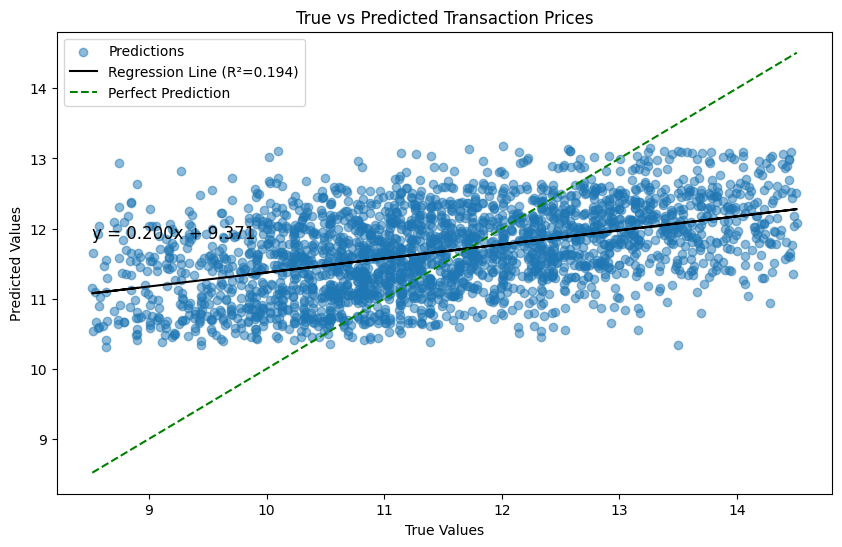

In [61]:
fit_visualization(target.ravel(), prediction_recurrent_model.ravel())